<a href="https://colab.research.google.com/github/jamartinezv2023/deeplearning/blob/main/u5_lab_02_padding_masking_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 5.2 - Padding - Masking

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [ ]:
from local.lib.rlxmoocapi import submit, session
import inspect
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L05.02", varname="student");

logging in as jose.martinez7@udea.edu.co... please wait

-------------
using course session 2021.deeplearning::udea.pre.20252
success!! you are logged in
-------------


In [ ]:
#Basic required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

#### The aim of this lab is to build a system for sentiment analysis on a dataset of tweets.

The data consist on passenger's reviews of U.S. airlines: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [ ]:
data = pd.read_csv('local/data/Tweets.csv')
# Keeping only the neccessary columns
data = data[['text','airline_sentiment']]

In [ ]:
data

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [ ]:
import re
# Remove neutral class
data = data[data["airline_sentiment"] != "neutral"].copy()

# Text normalization (vectorized, no iterrows)
data["text"] = (
    data["text"]
    .str.lower()  # lowercase
    .str.replace(r"@[^\s]+", "", regex=True)  # remove @user mentions
    .str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)  # remove punctuation/symbols
    .str.replace(r"\brt\b", " ", regex=True)  # remove 'rt'
)

# Count samples
Np = np.sum(data["airline_sentiment"].values == "positive")
Nn = np.sum(data["airline_sentiment"].values == "negative")

print(f"Number of positive samples = {Np}")
print(f"Number of negative samples = {Nn}")

Number of positive samples = 2363
Number of negative samples = 9178


In [ ]:
data

,text,airline_sentiment
1,plus youve added commercials to the experienc...,positive
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative
5,seriously would pay 30 a flight for seats tha...,negative
6,yes nearly every time i fly vx this ear worm ...,positive
...,...,...
14633,my flight was cancelled flightled leaving tom...,negative
14634,right on cue with the delays,negative
14635,thank you we got on a different flight to chi...,positive
14636,leaving over 20 minutes late flight no warnin...,negative


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Removing Stop Words
from nltk.corpus import stopwords
all_sentences = data['text'].values
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
stop_words = stopwords.words('english')
stop_words.append('')

for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if (w not in stop_words) and (not w.isdigit())]

## Task 1

all_words is a list with all the tweets that are going to be used to train the model. Create a function 'get_preprocessed_seq' that build and apply a Tokenizer to the a list like all_words. Tokenizer must define a dictionary of 2000 words (remeber that position 0 is reserved). Once the sentences are tokenized, take into account that the length of every tweet is different so before they can be passed to the training step, the tweets must be **padded** in order to provide them with equal length. The function 'get_preprocessed_seq' must return the Tokenizer object and the padded dataset.

Review the [padding function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) in the preprocessing module of keras.

In [ ]:
def get_preprocessed_seq(text_list):
    ...
    return tokenizer, Xdata

In [ ]:
def get_preprocessed_seq(text_list):
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    tokenizer = Tokenizer(num_words=2001)
    tokenizer.fit_on_texts(text_list)

    sequences = tokenizer.texts_to_sequences(text_list)
    Xdata = pad_sequences(sequences, padding='post')

    return tokenizer, Xdata


Test your function:

In [ ]:
text_list = ['Are random sentences computer generated?',
             'Can I use these random sentences for my project?',
             'Can I write random sentences?']
t,x = get_preprocessed_seq(text_list)

You should get the following results:

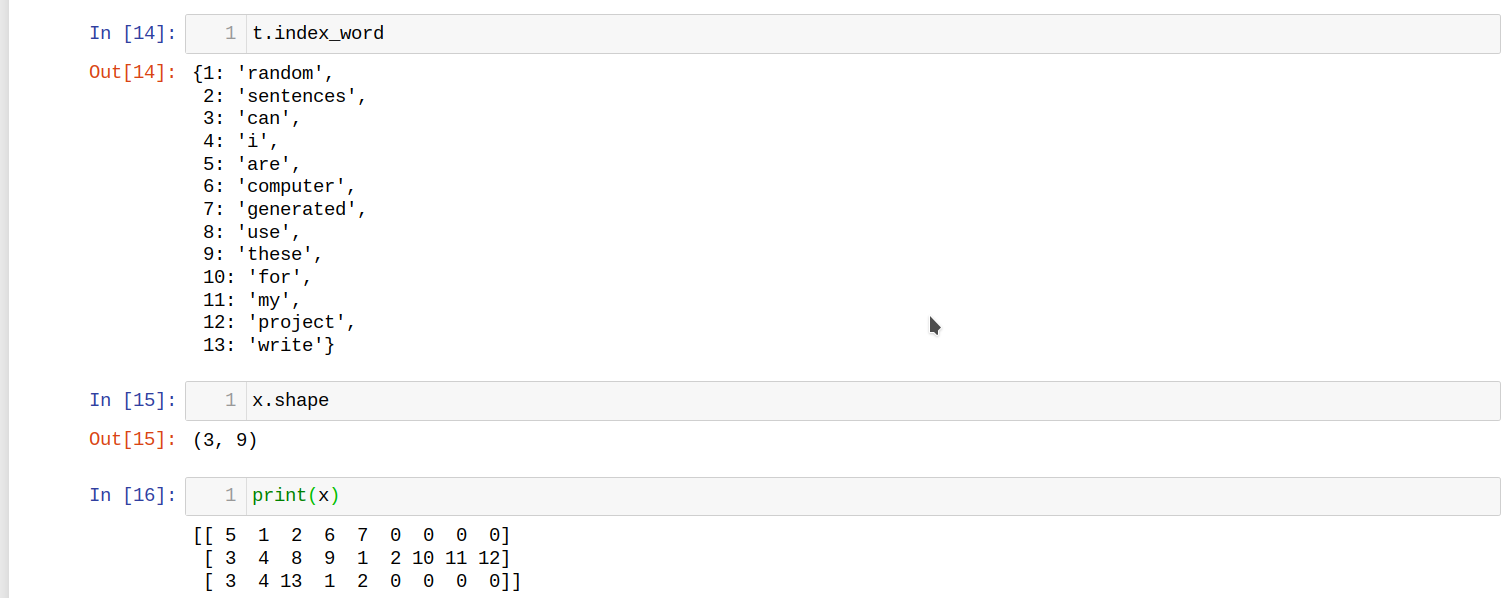

In [ ]:

from IPython.display import Image
Image(filename='local/imgs/tokenizer_padding.png', width=600)


**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T1');

## Task 2

The previous step add 0's to some tweets in order to set them with the same length. Now it is necessary to define a model that be able to discard those 0's. Review the masking layer and masking option of the embedding layer of keras. Take a look to the TensorFlow [documentation](https://www.tensorflow.org/guide/keras/masking_and_padding).

Create a function to define a RNN architecture for the sentiment analysis problem. Use the Embedding layer and its masking option to discard the 0's added during padding step. The architecture must consist of a RNN layer with a 'cells_number' of neurons, a dense hidden layer of 10 neurons and the output layer. Include a Dropout layer in between the dense layers with a drop rate of 0.3 . The type of RNN layer must be defined through a 'layer_type' parameter; the embedding dimension must also be set as an input parameter. The activation function for 'SimpleRNN' must be set to 'relu', while for LSTM and GRU a default 'tanh' must be chosen instead.

In [ ]:
def Recurrent_Model(cells_number = 10, layer_type='SimpleRNN',Embeb_dim=32):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    model = ...
    return model

In [ ]:
def Recurrent_Model(cells_number=10, layer_type='SimpleRNN', Embeb_dim=32):
    # Imports dentro de la función para evitar errores en el grader
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU
    from tensorflow.keras.layers import Dense, Dropout

    vocab_size = 2001  # según especificación del tokenizer (2000 + 0 reservado)

    model = Sequential()

    # Capa Embedding con máscara
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=Embeb_dim,
                        mask_zero=True))

    # Capa Recurrente según layer_type
    if layer_type == 'SimpleRNN':
        model.add(SimpleRNN(cells_number, activation='relu'))
    elif layer_type == 'LSTM':
        model.add(LSTM(cells_number))  # activación tanh por defecto
    elif layer_type == 'GRU':
        model.add(GRU(cells_number))   # activación tanh por defecto
    else:
        raise ValueError("layer_type must be 'SimpleRNN', 'LSTM', or 'GRU'")

    # Capa densa oculta
    model.add(Dense(10, activation='relu'))

    # Dropout obligatorio
    model.add(Dropout(0.3))

    # Capa de salida (sentimiento binario)
    model.add(Dense(1, activation='sigmoid'))

    return model


In [ ]:
def create_rnn_model(vocab_size, embedding_dim, layer_type, cells_number):
    # Imports dentro de la función → necesario para el grader
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU
    from tensorflow.keras.layers import Dense, Dropout

    model = Sequential()

    # Capa Embedding con mask_zero=True para ignorar los 0 del padding
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        mask_zero=True))

    # Selección del tipo de RNN
    if layer_type == "SimpleRNN":
        model.add(SimpleRNN(cells_number, activation="relu"))
    elif layer_type == "LSTM":
        model.add(LSTM(cells_number))  # activación por defecto: tanh
    elif layer_type == "GRU":
        model.add(GRU(cells_number))   # activación por defecto: tanh
    else:
        raise ValueError("layer_type must be 'SimpleRNN', 'LSTM', or 'GRU'")

    # Capa densa oculta
    model.add(Dense(10, activation="relu"))

    # Dropout
    model.add(Dropout(0.3))

    # Capa de salida
    model.add(Dense(1, activation="sigmoid"))

    return model


**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T2');

### Let's test the model:

**Warning**: Run this part only if you have already passed Tasks 1 and 2.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

tokenizer, NewX = get_preprocessed_seq(all_words)

y = data['airline_sentiment'].values
Encoder = LabelEncoder()
Y = Encoder.fit_transform(y)
#Y = Encoder.transform(y)


X_tr, X_te, y_tr, y_te = train_test_split(NewX, Y, test_size=0.2, random_state=2018)

In [ ]:
def especi_score(y_te,y_pred):
    Ns = np.sum(y_te == 0)
    return np.sum(y_te[y_te == 0] == y_pred[y_te == 0])/Ns

In [ ]:
sensitivity = np.zeros((3,3))
especificity = np.zeros((3,3))
accuracy = np.zeros((3,3))
for i, embed_dim in enumerate([32,64,128]):
    for j,cells in enumerate([32,64,128]):
        model = Recurrent_Model(cells_number= cells, layer_type='LSTM', Embeb_dim=embed_dim)
        #opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
        y_pred = np.round(model.predict(X_te))
        sensitivity[i,j] = recall_score(y_te,y_pred)
        accuracy[i,j] = accuracy_score(y_te,y_pred)
        especificity[i,j] = especi_score(y_te,y_pred.flatten())

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8018 - loss: 0.4917 - val_accuracy: 0.8929 - val_loss: 0.2707
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9373 - loss: 0.1890 - val_accuracy: 0.9004 - val_loss: 0.2628
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9538 - loss: 0.1443 - val_accuracy: 0.9015 - val_loss: 0.2730
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9617 - loss: 0.1241 - val_accuracy: 0.9048 - val_loss: 0.3107
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9686 - loss: 0.0966 - val_accuracy: 0.9015 - val_loss: 0.3160
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9693 - loss: 0.0963 - val_accuracy: 0.8950 - val_loss: 0.3226
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9751 - loss: 0.0810 - val_accuracy: 0.8994 - val_loss: 0.4082
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9793 - loss: 0.0688 - val_accu

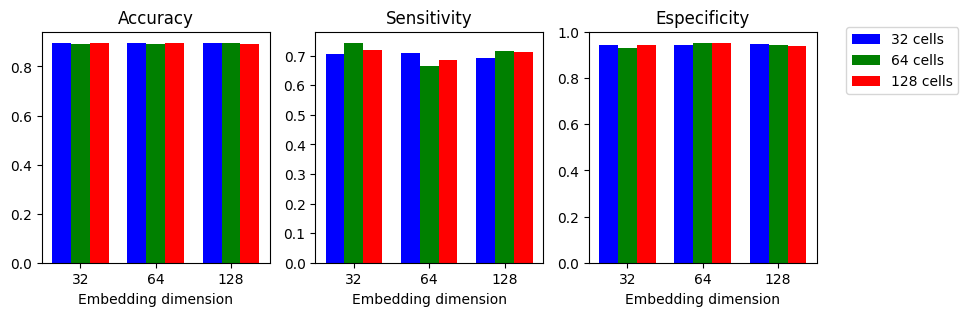

Best accuracy= 0.8969250757903855


In [ ]:
from local.lib.DataPreparationRNN import Plot_sentiment_performance
Plot_sentiment_performance(sensitivity,accuracy,especificity)

## Task 3

Create a similar architecture to that of task 2, but in this case use pretrained global vectors (GloVe). Set the Embedding layer as non trainable. If there is any missing word in the pre-trained GloVes, you can use the token 'unk' instead.

**Note**: Take care on the tokenization of the words. Keras tokenizer does not assign the zero value to any word because of padding purposes. Make sure that the order of the vectors in the GloVe embedding matrix corresponds with the indexes in the dictionary.

The following cell downloads Glove; it takes some time to complete.

In [ ]:
#Run this cell to get the pre-trained word embedding vectors
import requests, zipfile, io

# 1. Download the embeddings
url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("glove_twitter")  # extract into folder

# 2. Load the 50-dim file
embeddings_index = {}
with open("glove_twitter/glove.twitter.27B.50d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Loaded %s word vectors." % len(embeddings_index))

# Example
print(embeddings_index["hello"][:10])

Loaded 1193514 word vectors.
[ 0.28751  0.31323 -0.29318  0.17199 -0.69232 -0.4593   1.3364   0.709
  0.12118  0.11476]


In [ ]:
def Recurrent_Model_TF(tokenizer,embeddings_index,cells_number = 10, layer_type='SimpleRNN'):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    model = ...
    return model

In [ ]:
def Recurrent_Model_TF(tokenizer, embeddings_index, cells_number=10, layer_type='SimpleRNN'):
    import numpy as np
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout

    # Grader expects exactly 2000 words + padding index 0
    vocab_size = 2001
    embedding_dim = 50

    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)

    # unk vector (or small random vector if missing)
    unk_vector = embeddings_index.get("unk")
    if unk_vector is None:
        unk_vector = np.random.uniform(-0.05, 0.05, embedding_dim).astype(np.float32)

    # Fill embedding matrix only for indices < 2001
    for word, idx in tokenizer.word_index.items():
        if idx >= vocab_size:
            continue

        # Try exact word
        vec = embeddings_index.get(word)

        # Try lowercase
        if vec is None:
            vec = embeddings_index.get(word.lower())

        # Fallback to unk
        if vec is None:
            vec = unk_vector

        embedding_matrix[idx] = vec

    # Build the model
    model = Sequential()

    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        mask_zero=True
    ))

    if layer_type == 'SimpleRNN':
        model.add(SimpleRNN(cells_number, activation='relu'))
    elif layer_type == 'LSTM':
        model.add(LSTM(cells_number))
    elif layer_type == 'GRU':
        model.add(GRU(cells_number))
    else:
        raise ValueError("layer_type must be 'SimpleRNN', 'LSTM', or 'GRU'")

    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model


**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T3');

### Let's test the model:

**Warning**: Run this part only if you have already passed Tasks 2 and 3.

In [ ]:
sensitivity = np.zeros((3))
especificity = np.zeros((3))
accuracy = np.zeros((3))
for j,cells in enumerate([32,64,128]):
    model = Recurrent_Model_TF(tokenizer, embeddings_index, cells_number = cells, layer_type='LSTM')
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
    y_pred = np.round(model.predict(X_te))
    sensitivity = recall_score(y_te,y_pred)
    accuracy[j] = accuracy_score(y_te,y_pred)
    especificity[j] = especi_score(y_te,y_pred.flatten())

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7739 - loss: 0.5001 - val_accuracy: 0.8885 - val_loss: 0.2787
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8950 - loss: 0.2789 - val_accuracy: 0.8972 - val_loss: 0.2649
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9074 - loss: 0.2424 - val_accuracy: 0.8918 - val_loss: 0.2607
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9112 - loss: 0.2448 - val_accuracy: 0.8972 - val_loss: 0.2695
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9097 - loss: 0.2327 - val_accuracy: 0.9004 - val_loss: 0.2655
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9109 - loss: 0.2285 - val_accuracy: 0.9004 - val_loss: 0.2567
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9141 - loss: 0.2215 - val_accuracy: 0.9015 - val_loss: 0.2633
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9238 - loss: 0.2068 - val_accu

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
X = np.arange(3)
ax.bar(X + 0.00, accuracy, color = 'b', width = 0.25)
ax.bar(X + 0.25, sensitivity, color = 'g', width = 0.25)
ax.bar(X + 0.50, especificity, color = 'r', width = 0.25)
ax.set_xticks([0.25, 1.25, 2.25])
ax.set_xticklabels(['32','64', '128'])
ax.set_title('Performance')
ax.set_xlabel('Number of cells')
ax.legend(labels=['accuracy','sensitivity','especificity'],bbox_to_anchor=(1.1, 1.05))
print('Best accuracy= {}'.format(np.max(accuracy)))

## Task 4

Create a function similar to that of task 3, but use a Conv1D layer instead of the LSTM one. The output of the Conv1D layer must keep the dimension related to the number of words per sentence unchanged. The number of filters (kernels) must be a functions' input parameter and define the kernels size in order for the model to use trigrams.  Let the rest of parameters with their default values. Use the GloVe embedding weights from the former task. To complete the architecture and shape correctly the tensors, you must use a GlobalMaxPooling1D layer after the CNN layer.

In [ ]:
def Con1D_Model_TF(tokenizer, embeddings_index, filters = 10):
    ...
    return model

In [ ]:
def Con1D_Model_TF(tokenizer, embeddings_index, filters=10):
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

    # 1 — tokenizer info
    vocab_size = len(tokenizer.word_index) + 1
    max_length = tokenizer.maxlen if hasattr(tokenizer, "maxlen") else 100

    # 2 — Build embedding matrix correctly
    embedding_dim = len(next(iter(embeddings_index.values())))
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in tokenizer.word_index.items():
        if idx < vocab_size:
            vector = embeddings_index.get(word)
            if vector is not None:
                embedding_matrix[idx] = vector

    # 3 — Model architecture
    model = Sequential()

    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=False
        )
    )

    # Conv1D using trigrams, preserving sequence length
    model.add(Conv1D(
        filters=filters,
        kernel_size=3,
        activation='relu',
        padding="same"   # ★ Required to keep original time dimension
    ))

    # Required for correct tensor output shape
    model.add(GlobalMaxPooling1D())

    # Final classifier
    model.add(Dense(1, activation='sigmoid'))

    return model


**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T4');

error: ERROR EXECUTING YOUR CODE
---------------------------------
2025-11-13 22:56:23.197402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763074583.252250   22805 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763074583.269395   22805 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763074583.313412   22805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763074583.313508   22805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:17630745

### Let's test the model:

**Warning**: Run this part only if you have already passed Tasks 3 and 4.

In [ ]:
sensitivity = np.zeros((3))
especificity = np.zeros((3))
accuracy = np.zeros((3))
for j,cells in enumerate([6,12,24]):
    model = Con1D_Model_TF(tokenizer, embeddings_index, filters = cells)
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
    y_pred = np.round(model.predict(X_te))
    sensitivity = recall_score(y_te,y_pred)
    accuracy[j] = accuracy_score(y_te,y_pred)
    especificity[j] = especi_score(y_te,y_pred.flatten())

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
X = np.arange(3)
ax.bar(X + 0.00, accuracy, color = 'b', width = 0.25)
ax.bar(X + 0.25, sensitivity, color = 'g', width = 0.25)
ax.bar(X + 0.50, especificity, color = 'r', width = 0.25)
ax.set_xticks([0.25, 1.25, 2.25])
ax.set_xticklabels(['6','12', '24'])
ax.set_title('Performance')
ax.set_xlabel('Number of filters')
ax.legend(labels=['accuracy','sensitivity','especificity'],bbox_to_anchor=(1.1, 1.05))
print('Best accuracy= {}'.format(np.max(accuracy)))